# Online DA-BN Tutorial 
We assume basic knowledge of the PyTorch framework: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
# standard
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


# custom
from sampler.sampler import DomainBatchSampler
from norm_layers.static import StaticDABatchNorm
from norm_layers.online import OnlineDABatchNorm

In [2]:
# reproduce
seed = 2
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Data

We create some random dummy data with marginal distribution shift for demonstration purposes

In [3]:
class MyDataset(Dataset):
    
    def __init__(self, X, y, dom):
        super(MyDataset, self).__init__()
        self.X = X
        self.y = y.long()
        self.dom = dom
    
    def __getitem__(self, index):
        return (self.X[index], self.y[index], self.dom[index])
    
    def __len__(self):
        return self.X.size(0)

Train

In [4]:
# We create 2000 datapoints, 1000 points per domain -> 2 domains
feat_inp = torch.rand(2000, 2)
feat_inp[:1000,:] = feat_inp[:1000,:] -2 # domain shift 
feat_inp[:500, :] = feat_inp[:500, :] +1 # class 
feat_inp[1000:1500, :] = feat_inp[1000:1500, :] +1 # class 
dom_inp = torch.cat([torch.ones(1000)*3, torch.ones(1000) * 5]).long() # Note: domains are labeled '3' and '5'
lab_inp = torch.cat([torch.zeros(500), torch.ones(500)]).long()
lab_inp = torch.cat([lab_inp, lab_inp])

In [5]:
# each domain must have same no of instances. No of instances per domain must be a multiple of batch size
batch_size = 100
sampler = DomainBatchSampler(1000, 2, batch_size) 
data = MyDataset(feat_inp, lab_inp, dom_inp)
dataloader = DataLoader(data, batch_sampler=sampler)

Test

In [6]:
test_feat = torch.rand(1000, 2) -4
test_feat[:500, :] = test_feat[:500, :] +1 # class change
test_lab = lab_inp[:1000]

# randomize order
test_permut_idx = torch.randperm(len(test_feat))
test_feat = test_feat[test_permut_idx]
test_lab = test_lab[test_permut_idx]

We have 2 source domains and a target domain with shifted marignal but same conditional distributions.

In [7]:
# Concat domains for viz
tmp_feat = torch.cat([feat_inp, test_feat]).numpy()
tmp_lab = torch.cat([lab_inp, test_lab]).numpy()
tmp_dom = torch.cat([torch.zeros(1000, dtype = torch.long), torch.ones(1000, dtype = torch.long), torch.ones(1000, dtype = torch.long)*2]).numpy()
#full = pd.DataFrame([tmp_feat[:,0], tmp_feat[:,1], tmp_lab, tmp_dom], index = ["x", "y", "lab", "domain"]).transpose()

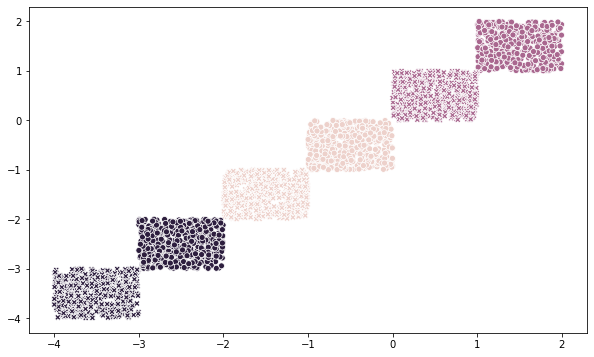

In [8]:
# Distribution of source domains and target domain. Domains colored. Classes seperated with markers.
plt.figure(figsize=(10,6))
plot = sns.scatterplot(x = tmp_feat[:, 0], y=tmp_feat[:, 1], hue = tmp_dom, style=tmp_lab)
plot.legend_.remove()

----

## Networks with DA-BN
Note that we implemented also a class `PreEstimateOnlineDABatchNorm`. Its like the `OnlineDABatchNorm` but computes a inital estimate of the target statistics from a small batch. Therefore, it basically needs a `init_target()` method like the `StaticNet` and a `__init__()` method like the `OnlineNet`.  `forward()` is the same for all version. 

In [9]:
n_neurons = 2 
domain_lst = [3,5] # domains are labeled 3 and 5 see above 
no_classes = 2
epochs = 100 # we overfit the model on purpose for demonstration
learning_rate = 0.01
decay = 0.001
criterion = torch.nn.CrossEntropyLoss()

In [10]:
# Note that DA-BN is only implemented for fully connected layer

class StaticNet(nn.Module):

    def __init__(self):
        super(StaticNet, self).__init__()
        self.linear1 = nn.Linear(2, n_neurons)
        self.norm = StaticDABatchNorm(n_neurons, domain_lst)  # input dim and domain_lst must be passed. See doc for all arguments
        self.linear2 = nn.Linear(n_neurons, 2)
        self.relu =  nn.ReLU()

    # forward must add. receive 1dim tensor 'domains' containing domain ids of batch input instances for training. Must be same domain within a batch
    def forward(self, input, domains=None):
        
        if (self.training) & (type(domains) == type(None)):
            raise ValueError("domains must not be None during training")
        
        output = self.linear1(input)
        output = self.norm(output, domains) # 'domains' gets passed as 2nd arg. During testing 'domains' is not used by forward of DABatchNorm layer
        output = self.relu(output)
        output = self.linear2(output)
        return output
    
    # Before testing DA-BN layers need to esimate domain-specific statistics with a pre-estimation batch
    def init_target(self, estimation_batch):
        if self.training: raise Exception("init_target must happend during testing phase")
        processed = self.linear1(estimation_batch)
        self.norm.init_target(processed) 
        # If you would have multiple DA-BN layers you must process the estimation_batch until the last BN 
        # processed = self.norm(processed)
        # self.relu(processed)
        # processed = self.linear2(processed)
        # self.norm2.init_target(processed) 
        # ...
        
        
class OnlineNet(nn.Module):

    def __init__(self):
        super(OnlineNet, self).__init__()
        self.linear1 = nn.Linear(2, n_neurons)
        # Equivalently to static input dim and domain_lst must be passed. Additionally online adaptation momentum ('test_momentum') must be passed
        # See doc for all arguments
        self.norm = OnlineDABatchNorm(n_neurons, domain_lst, test_momentum=0.1)  
        self.linear2 = nn.Linear(n_neurons, 2)
        self.relu =  nn.ReLU()

    # forward must add. receive 1dim tensor 'domains' containing domain ids of batch input instances for training. Must be same domain within a batch
    def forward(self, input, domains=None):
        
        if (self.training) & (type(domains) == type(None)):
            raise ValueError("domains must not be None during training")
        
        output = self.linear1(input)
        output = self.norm(output, domains) # 'domains' gets passed as 2nd arg. During testing 'domains' is not used by forward of DABatchNorm layer
        output = self.relu(output)
        output = self.linear2(output)
        return output
    
    # Before testing Online DA-BN layers need to estimate initial domain-specific statistics as average of running statistics from training 
    def init_target(self):
        self.norm.init_target()
        # If you would have multiple DA-BN layers 
        # self.norm2.init_target()
        # ...

----

## Training

In [11]:
# training procedure is the same for static and online DA-BN
def train(net, optimizer, dataloader):
    net = net.train()
    for epoch in range(epochs):
        for feat, lab, dom in dataloader:
            optimizer.zero_grad()
            output = net(feat, dom) # during training not only batch of features but batch of corresponding domain ids gets passed
            loss = criterion(output, lab)
            loss.backward()
            optimizer.step()
    return net

In [12]:
static_net = StaticNet()
static_optimizer = torch.optim.SGD(static_net.parameters(), lr=learning_rate, weight_decay = decay)

In [13]:
online_net = OnlineNet()
online_optimizer = torch.optim.SGD(online_net.parameters(), lr=learning_rate, weight_decay = decay)

In [14]:
static_net = train(static_net, static_optimizer, dataloader)
online_net = train(online_net, online_optimizer, dataloader)

## Testing

In [15]:
def accur(output, lab):
    """Compute accuracy from output and labels"""
    _, predicted = torch.max(output, 1)
    correct = (predicted == lab).sum().item()
    total = lab.size(0)
    accur = round(correct / total, 4)
    return accur

In [16]:
static_net = static_net.eval()

static_net.init_target(test_feat) # we use the whole test data to estimate the DA-BN statistics in this case before applying the model to the testing data

with torch.no_grad():
    output = static_net(test_feat) # simply pass 
print( "Accuracy with adaptation:", accur(output, test_lab))

Accuracy with adaptation: 1.0


In [17]:
static_net = static_net.eval()

# Using regular BatchNorm the global BN statistics would be an expo. average over the training data. We approx. it here for simplicity as the average over 
# the entire training batch. Note that we were still adapting during training though. 
static_net.init_target(feat_inp) 

with torch.no_grad():
    output = static_net(test_feat)
print( "Accuracy without adaptation:", accur(output, test_lab))

Accuracy without adaptation: 0.5


In [18]:
# We pass a single instance at once to the model. 
# It is also possible to pass small batches. In that case mean and variance is computed over the small batch, updated with previous 
# estimates using exponential average and classified. 

online_net = online_net.eval()
online_net.init_target() # No arguments

outputs = []

with torch.no_grad():
    for feat in test_feat:
        outputs.append(online_net(feat.view(1, 2))) # because feat.size == (2) and not (1,2)

output = torch.cat(outputs)
print("Accuracy with online adaptation", accur(output, test_lab))

Accuracy with online adaptation 0.977
